In [1]:
# importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

In [2]:
from sklearn.datasets import fetch_openml
X_mnist, y_mnist = fetch_openml("mnist_784",version=1,return_X_y=True,as_frame=False)
#make the data into usable form
y_mnist = y_mnist.astype('int')
X_mnist = X_mnist/255.0

/hdd_home/anaconda/envs/deep_learning_mainak/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


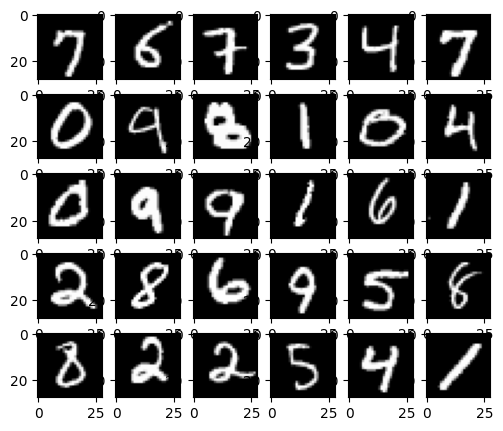

In [3]:
def display_grid(list_conn, num_col):
    num_row = int(list_conn.shape[0]/num_col)
    
    fig, axes = plt.subplots(num_row, num_col, figsize=(num_col,num_row))
    for i in range(num_col*num_row):
        #ax.set_title("Conn. matrix (log scale), S = "+str(i+1), fontsize=12)
        ax = axes[i%num_row, int(i/num_row)]
        full_im = ax.imshow(list_conn[i].reshape((28,28)), cmap='gray')
    
    #make room for the colourbar on the right and plot it
    fig.subplots_adjust(right=0.88)
    plt.show()

display_grid(X_mnist[np.random.choice(np.arange(X_mnist.shape[0]), 30)], 6)

In [4]:
def get_sub_sample_10k(X, y, n_perclass=1000):
    np.random.seed(24)   #so that the same split is obtained always
    list_10k = [] 
    for label in np.unique(y):
        indices = np.where(y==label)[0]
        np.random.shuffle(indices)
        list_10k += list(indices[0:1000]) 
    return X[list_10k], y[list_10k]
X_10k, y_10k = get_sub_sample_10k(X_mnist, y_mnist)

In [5]:
print(X_10k.shape, y_10k.shape)

(10000, 784) (10000,)


# Principal Component Analysis

In [9]:
# I am not implementing PCA but using the sklearn vesion of it - because it is one of the assignment 4 problems
def PCA(X, nc=2):
    from sklearn.decomposition import PCA 
    pca_obj = PCA(n_components=2)
    Z = pca_obj.fit_transform(X)
    print("Original Dimension: {}, Reduced Dimension: {}".format(X.shape, Z.shape))
    return Z

In [10]:
Z_10k = PCA(X_10k)

Original Dimension: (10000, 784), Reduced Dimension: (10000, 2)


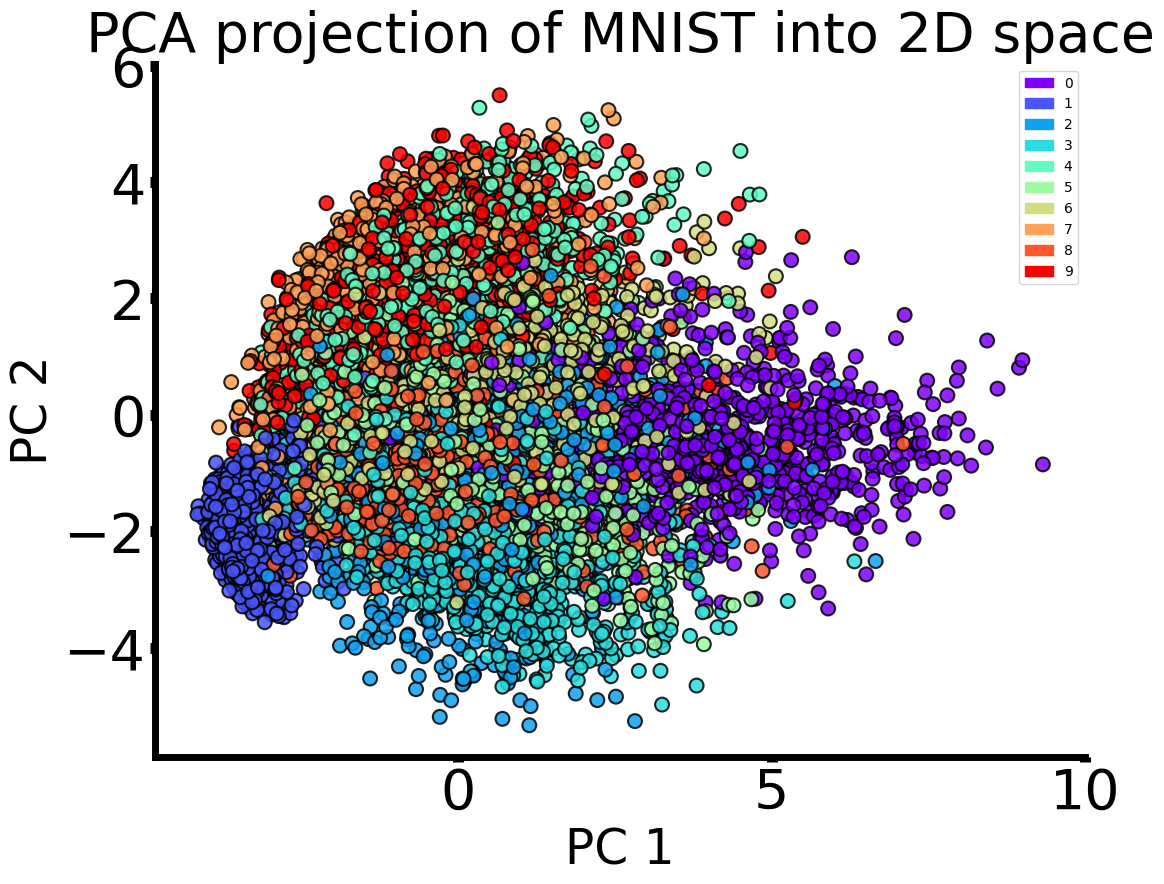

In [202]:
def plot_scatter_classwise(Z, y, xlab='PC 1', ylab='PC 2', title_="PCA projection of MNIST into 2D space", addon="", n_c = 10):
    #for every label plot the scatter plot
    fig, ax = plt.subplots(figsize=(12, 9))
    mn_x, mx_x = np.min(Z[:, 0]), np.max(Z[:, 0])
    mn_y, mx_y = np.min(Z[:, 1]), np.max(Z[:, 1])
    plt.xlabel(xlab, fontsize=35)
    plt.ylabel(ylab, fontsize=35)
    plt.title(title_, fontsize=40)
    
    rng = (mx_x - mn_x)
    mn_x = mn_x - 0.05*rng
    mx_x = mx_x + 0.05*rng
        
    rng = (mx_y - mn_y)
    mn_y = mn_y - 0.05*rng
    mx_y = mx_y + 0.05*rng
    plt.xlim([mn_x, mx_x])
    plt.ylim([mn_y, mx_y])

    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=40)
    
    colours = cm.rainbow(np.linspace(0, 1, n_c))
        
    x_r = []
    y_r = []
    c_r = []
    for i in range(y.shape[0]):
        x_r.append(Z[i, 0])
        y_r.append(Z[i, 1])
        c_r.append(colours[y[i]])
        
        #print(Z_i.shape)
    np.random.seed(24)
    x_r, y_r, c_r = np.array(x_r), np.array(y_r), np.array(c_r)
    perm = np.random.permutation(len(x_r))
    x_r = x_r[perm]
    y_r = y_r[perm]
    c_r = c_r[perm]
        
    plt.scatter(x_r, y_r, color=c_r, alpha=0.85, s=100, edgecolor='black', linewidth=1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.tick_params(width=8)

    patches = []
    for i in np.unique(y):
        patches.append(mpatches.Patch(color=colours[i], label=addon+str(i)))
    
    plt.legend(handles=patches)


plot_scatter_classwise(Z_10k, y_10k)

# EM for Gaussian Mixture Model

In [256]:
class GMM:
    def __init__(self, n_c, X):
        self.k = n_c      # number of mixtures
        self.X = X  #(N, d)
        # the variational distribution q(z = j | X_i) = q_ij -> dimension (N, k)  
        self.q = None
        #dimension (k, d) -> k normals, d features each
        self.mus = None
        #multinomial - (k,)
        self.alphas = None
        #dimension (k, d, d) -> k normals, (dxd) 
        self.Sigmas = None
        #initialize the parameters
        self.initialize_params()
        print("Data dimension: {} \nDim. alphas: {} \nDim. mus: {}, \nDim. Sigmas: {} \nDim q: {}".format(self.X.shape, self.alphas.shape, self.mus.shape, self.Sigmas.shape, self.q.shape))
        
    def initialize_params(self):
        np.random.seed(99)
        #list you want to append
        mus = []
        # for the features randomly set the means of the distributions
        #covariance of the data
        sigma_data = np.cov(self.X.T)
        
        for i in range(self.X.shape[1]):
            mus.append(np.random.normal(loc=np.mean(self.X[:, i]), scale=np.std(self.X[:, i]), size=(self.k, 1)))
            
        #The sigmas of all the normals is set to the covariance of the data 
        self.Sigmas = np.repeat(np.expand_dims(sigma_data, axis=0), self.k, axis=0)
        self.alphas = np.repeat(1./self.k, self.k)
        #setting uniform probabilities for each datapoint in the variational distribution
        self.q = np.repeat(np.expand_dims(self.alphas, axis=0), self.X.shape[0], axis=0)
        self.mus = np.concatenate(mus, axis=1)
        
    def get_all_normal_values(self):
        # get the normal pdf value of all the data points for all the normals in the GMM (N, k) 
        all_normal_vals = np.zeros((self.X.shape[0], self.k))
        #all k inverses are calculated at once - will be of the shape (k, d, d) and (d)
        Sigmas_inverses = np.linalg.inv(self.Sigmas)
        Sigmas_det_root = np.sqrt(np.abs(np.linalg.det(self.Sigmas)))
        d_by2 = (self.X.shape[1])/2
        for i in range(self.k):
            #calculate the normal values for all the data points and a single normal
            for j in range(self.X.shape[0]):
                exp_term_ij = np.exp(-0.5* (self.X[j, :] - self.mus[i, :]).T @ Sigmas_inverses[i, :, :] @ (self.X[j, :] - self.mus[i, :]))
                all_normal_vals[j, i] = (1./((2*np.pi)**d_by2 * Sigmas_det_root[i])) * exp_term_ij
            
        return all_normal_vals
        
    def Expectation(self):
        all_normal_vals = self.get_all_normal_values()
        #calculate the variational distribution: dimension of q: (N, k)
        #print(np.expand_dims(self.alphas, axis=0).shape)
        q_alpha_prod = np.expand_dims(self.alphas, axis=0) * all_normal_vals
        #normalize all the qs by the sum across k normals
        self.q = q_alpha_prod / np.sum(q_alpha_prod, axis=1, keepdims=True)
        
    def Maximization(self):
        #set the variational distribution q
        self.alphas = np.mean(self.q, axis=0)
        
        #print(np.sum(self.alphas))
        norm_term = np.expand_dims(self.X.shape[0] * self.alphas, axis=1)  #converting it to kx1
        
        self.mus = (self.q.T @ self.X) / norm_term
        
        #Sigmas = np.zeros(self.Sigmas.shape)
        for i in range(self.k):
            #X has examples in the rows
            mu_i = np.expand_dims(self.mus[i, :], axis=0)
            #\|q (X-u)
            X_tilde = (self.X - mu_i) * np.sqrt(np.expand_dims(self.q[:, i], axis=1))
            self.Sigmas[i, :, :] = X_tilde.T @ X_tilde
        
        #norm term must be  kx1x1
        norm_term = np.expand_dims(norm_term, axis=2)
        self.Sigmas /= norm_term

    def run_EM(self, max_iter=100):
        for i in range(max_iter):
            self.Expectation()
            self.Maximization()
    
    def return_clustering(self):
        pred_prob = self.get_all_normal_values()
        pred_class = np.argmax(pred_prob, axis=1).astype('int')
        return pred_class

In [257]:
n_components = 10
gmm_obj = GMM(n_c=n_components, X=Z_10k)

Data dimension: (10000, 2) 
Dim. alphas: (10,) 
Dim. mus: (10, 2), 
Dim. Sigmas: (10, 2, 2) 
Dim q: (10000, 10)


In [258]:
gmm_obj.run_EM()

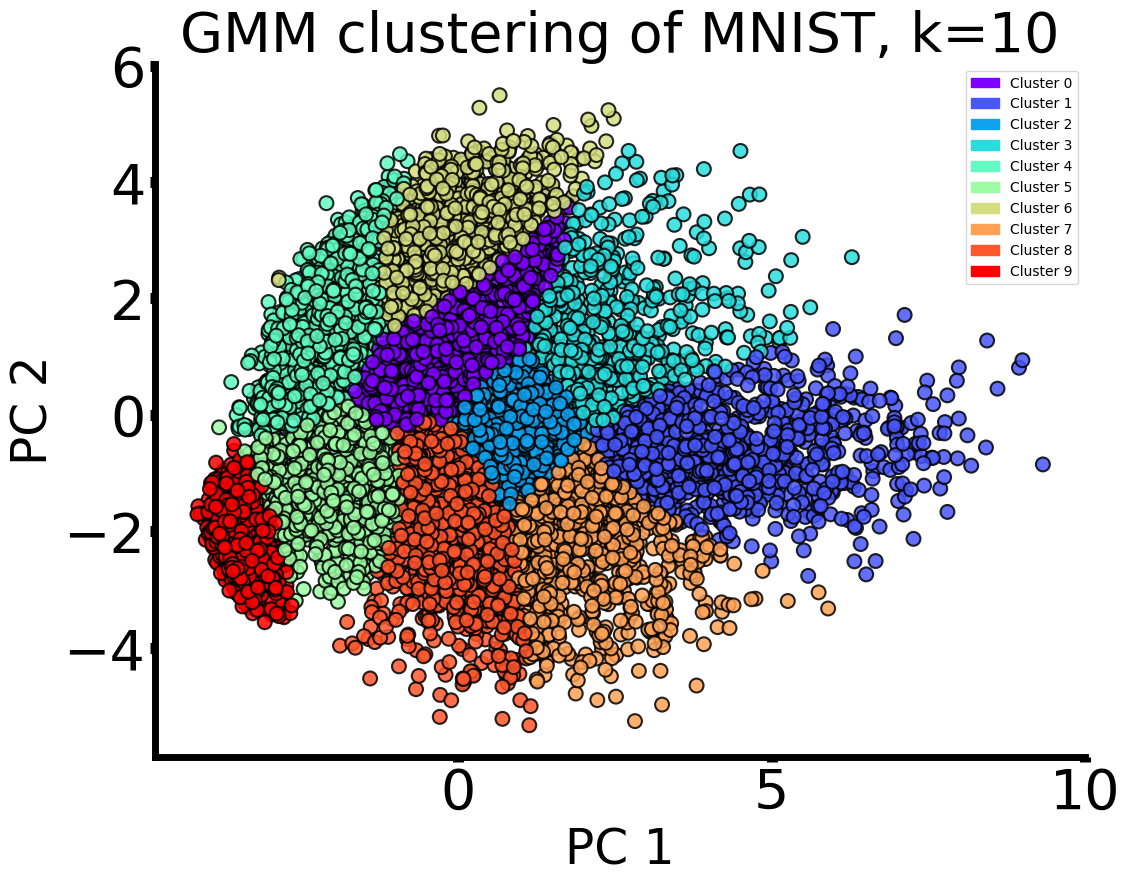

In [260]:
cluster_labels = gmm_obj.return_clustering()

plot_scatter_classwise(Z_10k, np.squeeze(cluster_labels), xlab='PC 1', ylab='PC 2', title_="GMM clustering of MNIST, k=10", addon="Cluster ", n_c=n_components)

Data dimension: (10000, 2) 
Dim. alphas: (5,) 
Dim. mus: (5, 2), 
Dim. Sigmas: (5, 2, 2) 
Dim q: (10000, 5)


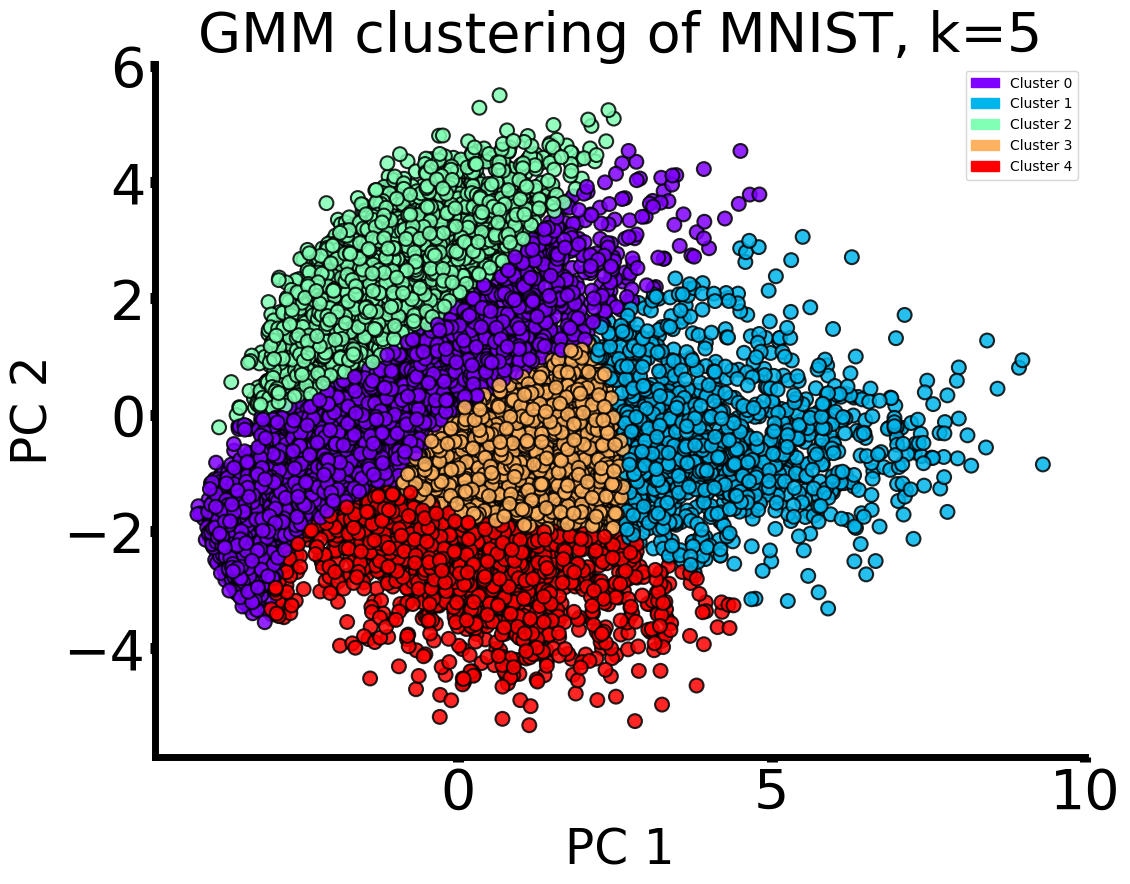

In [261]:
n_components = 5
gmm_obj = GMM(n_c=n_components, X=Z_10k)
gmm_obj.run_EM()
cluster_labels = gmm_obj.return_clustering()
plot_scatter_classwise(Z_10k, np.squeeze(cluster_labels), xlab='PC 1', ylab='PC 2', title_="GMM clustering of MNIST, k=5", addon="Cluster ", n_c=n_components)